# Import Libraries

In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Prepare the data

In [2]:
data = pd.read_csv('Value Data 1.csv')

# Convert Unix timestamps to datetime
data['Time'] = pd.to_datetime(data['Time (Unix)'], unit='s')
data.set_index('Time', inplace=True)

In [3]:
data.head()

,Time (Unix),Time (yyyy-mm-dd hh:mm:ss),Value
Time,,,
2024-06-05 14:43:00,1717598580,2024-06-05 14:43:00,0.316849
2024-06-05 14:44:00,1717598640,2024-06-05 14:44:00,0.297183
2024-06-05 14:45:00,1717598700,2024-06-05 14:45:00,0.280789
2024-06-05 14:46:00,1717598760,2024-06-05 14:46:00,0.277517
2024-06-05 14:47:00,1717598820,2024-06-05 14:47:00,0.284546


- Extract the series

In [4]:
series = data['Value']

# Anlysis for applying SARIMAX model

### Visualize the original data

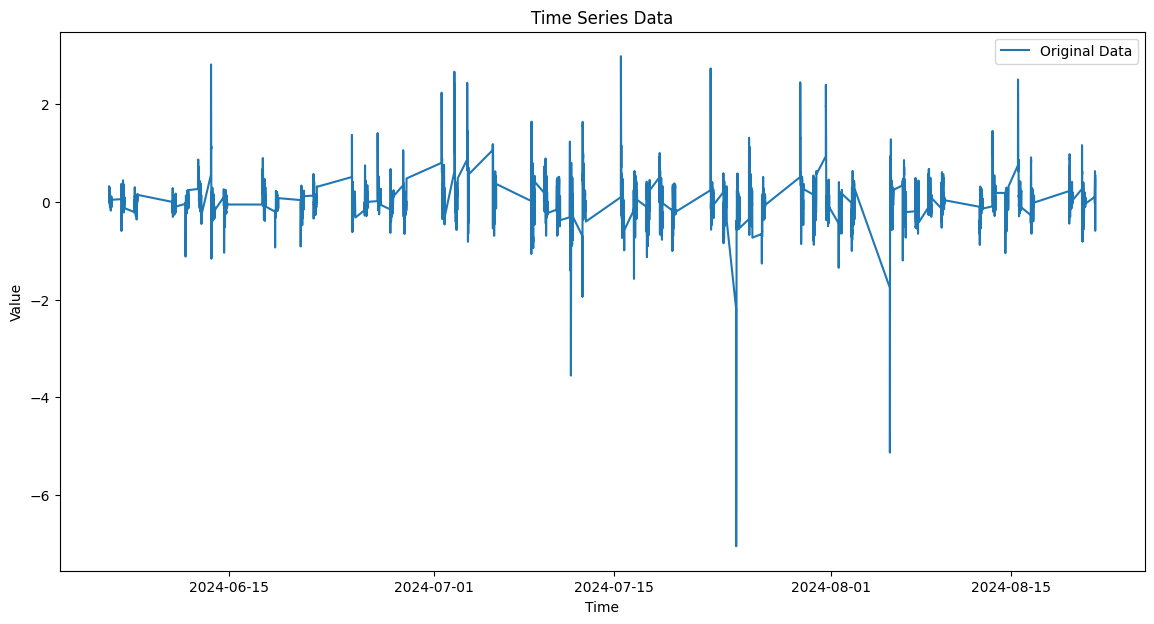

In [5]:
plt.figure(figsize=(14, 7))
plt.plot(series, label='Original Data')
plt.title('Time Series Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

### Decompose the series into trend, seasonal, and residual components

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

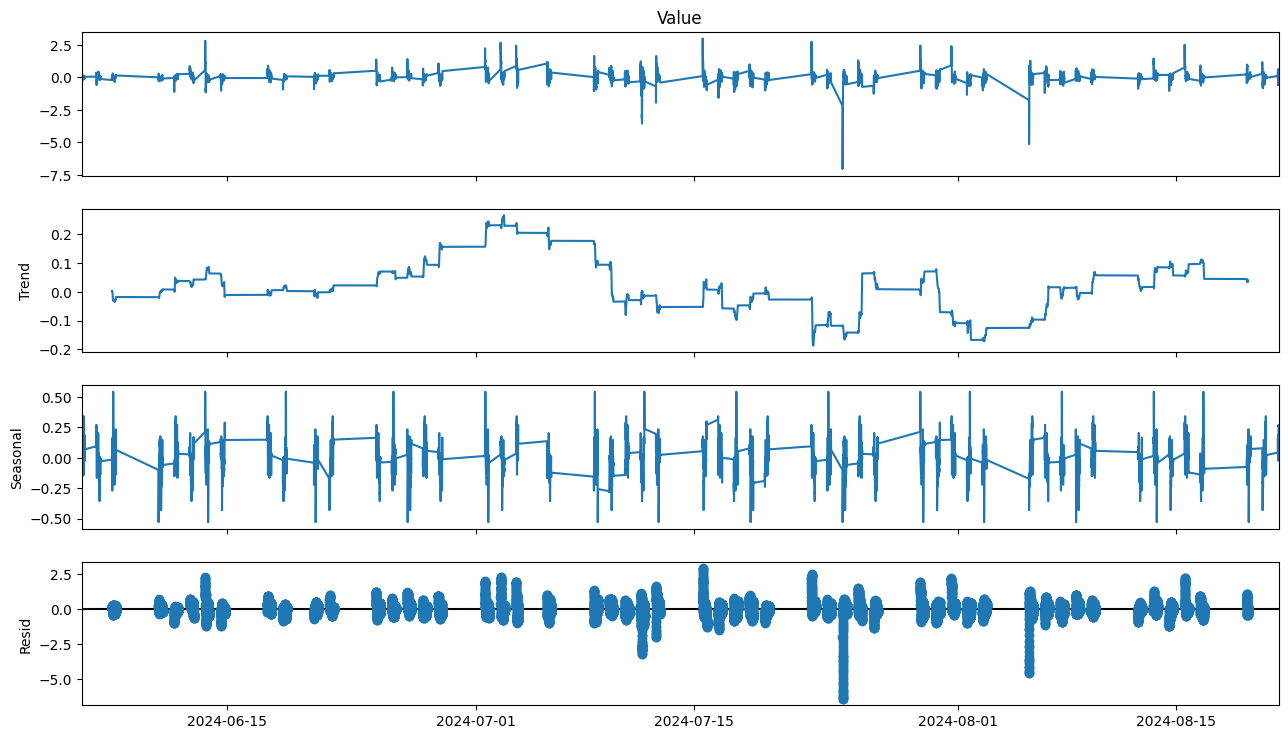

In [7]:
decomposition = seasonal_decompose(series, model='additive', period=1440) # 1440 = 24(hrs) * 60(mins)
fig = decomposition.plot()
fig.set_size_inches(14, 8)
plt.show()

1. Trend Component

1) **Purpose**<br>
The trend component reflects the long-term progression of the time series. It represents the underlying direction in which the data is moving over time, ignoring short-term fluctuations.

2) **Interpretation**<br>
- **Upward Trend**: Indicates that, over time, the data is increasing. This might suggest growth in the underlying phenomenon.
- **Downward Trend**: Indicates that, over time, the data is decreasing. This might suggest a decline in the underlying phenomenon.
- **No Trend**: If the trend line is flat, there is no significant long-term increase or decrease.

**No Dominant Trend**: The absence of a clear upward or downward trend suggests that the data does not have a long-term increase or decrease over the period observed. Instead, the data seems to oscillate around a mean value, which could mean that any trend present is weak or that the time frame selected does not cover a significant period to observe a clear trend.

**Volatility**: The frequent fluctuations could indicate high volatility in the data. This might be characteristic of financial time series, where prices or values can change rapidly and frequently.

**Possibility of Overfitting**: If the trend line appears to fit every small fluctuation, it might be capturing noise instead of the true underlying trend. This could be a sign that the seasonal decomposition model or the smoothing parameters used are too sensitive.

3) **Action**<br>
Depending on the trend, we might adjust our model to account for this long-term movement. For example, if there is a strong upward trend, our forecasting model should be able to capture this to avoid under-prediction.

- Check the Seasonal Component: Given the weak trend, it is important to check the seasonal component next. If strong seasonality is present, it might dominate the time series behavior, and the trend could be less significant.

- Consider Detrending: If the trend is weak or not useful, you might consider focusing more on the seasonal component and residuals. Alternatively, detrending (removing the trend) can be useful to focus on other aspects of the data.

- Parameter Tuning: You may need to adjust the parameters of the SARIMAX model.

- Revisit Data Frequency: Ensure that the data frequency is appropriate. Sometimes, aggregating data (e.g., from minute-level to hourly) can help smooth out volatility and reveal a clearer trend.



2. Seasonal Component<br>

1) **Purpose**<br>
  The seasonal component captures the repeating patterns or cycles in the data that occur at regular intervals (e.g., daily, weekly, monthly).<br>

2) **Interpretation**<br>
  - **Clear Seasonality**: If the seasonal component shows clear peaks and troughs at regular intervals, this indicates a strong seasonal pattern. For example, retail sales data might have strong seasonal effects with peaks around holidays.<br>
  - **No Seasonality**: If the seasonal component is flat, the data likely does not have a strong seasonal pattern.<br>
  - **Seasonal Periodicity**: The periodicity (how often the pattern repeats) will be evident in the seasonal plot. For example, daily data might show a weekly seasonal pattern.<br>

  The seasonal component in the plot you can see exhibits regular fluctuations, indicating the presence of daily seasonality in your data.

   (1) *Regularity and Pattern of Fluctuations*:
The plot shows repeated patterns that seem to occur consistently over time. This is a clear indication of daily seasonality, where certain patterns or behaviors repeat within the same period every day.
The peaks and troughs suggest that there are specific times during the day when the values tend to increase or decrease. For example, these could correspond to market open and close times, or other events that happen regularly every day.

  (2) *Amplitude of Seasonal Component*:
The amplitude of the seasonal component (the distance between the peaks and troughs) suggests how significant the seasonal effect is. In your plot, there are noticeable changes, indicating that seasonality plays a significant role in the data's variability.
If the amplitude were very small, it might suggest weaker seasonality, but in your case, it is relatively prominent.

  (3) *Noise and Irregularities*:
Although the seasonality is evident, there is also some noise, indicated by the irregular spikes and dips. This suggests that while there is a seasonal pattern, there is also some volatility or randomness in the data.
This might require further filtering or smoothing if these irregularities are not of interest or are considered noise.
  
3) **Action**<br>
  
> From the analysis, we can select the parameter `s`(seasonlity) of your data can be selected as `1440`.

3. Residuals Component

1) **Purpose**<br>
 The residual component represents the noise or the irregular component of the time series after removing the trend and seasonal components. Ideally, residuals should be random, with no discernible pattern.

2) **Interpretation**<br>
 - **Random Residuals**: If the residuals look random, it suggests that the trend and seasonal components have been well captured by the decomposition, leaving behind only noise.
 - **Patterned Residuals**: If there are patterns left in the residuals (e.g., autocorrelation, spikes, trends), it may indicate that the model has not fully captured some aspects of the data. This could be a sign that there is still some structure in the data not accounted for by the model.

 In the plot, the residuals are mostly centered around zero, but there are noticeable clusters and spikes. This suggests that while the model has captured a good portion of the variability, there might still be some structure left in the residuals.

3) **Action**<br>
 If the residuals are not random, you may need to revisit your model. It could mean you need a more complex model or additional variables to capture the remaining patterns.

### ACF and PACF plots to determine AR and MA components

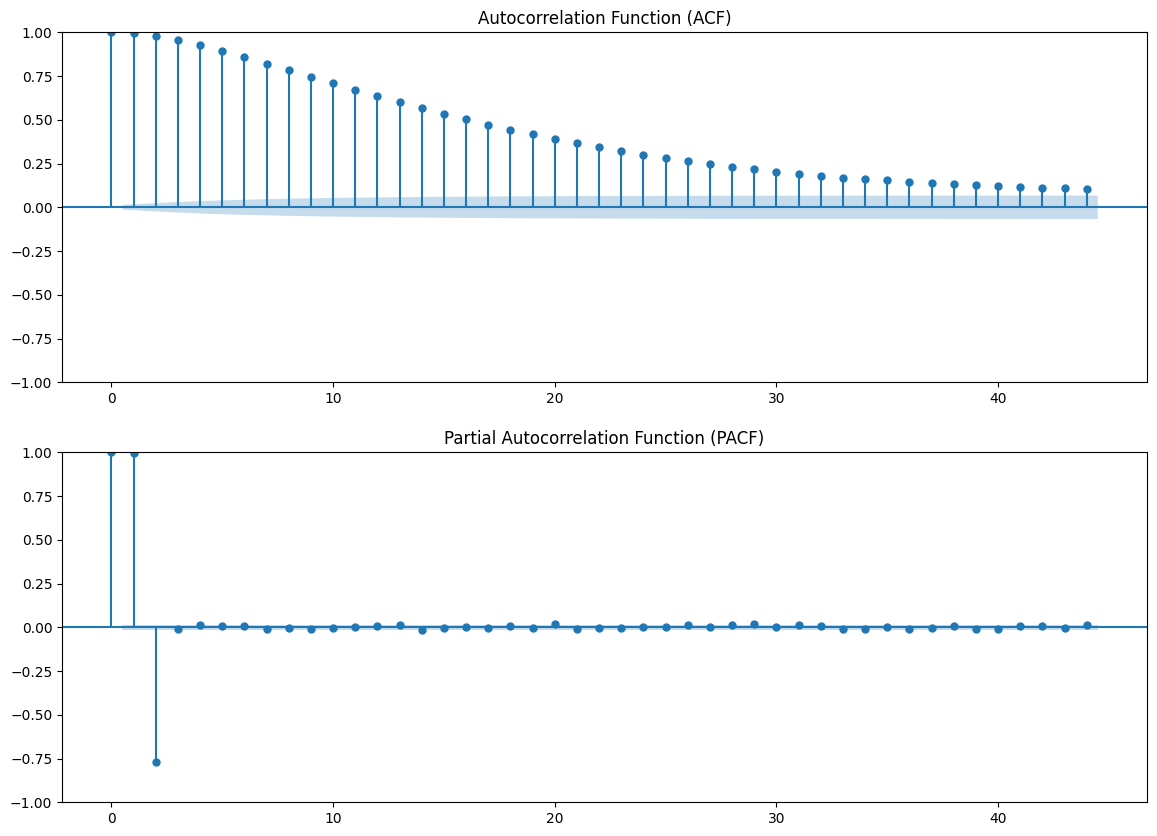

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(14, 10))
plot_acf(series, ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF)')
plot_pacf(series, ax=ax[1])
ax[1].set_title('Partial Autocorrelation Function (PACF)')
plt.show()

1. **ACF Plot**

   1) **Purpose**<br>
   To help determine the `q` (MA) and `Q` (seasonal MA) parameters by identifying how past values are related to current values.

   2) **Interpretation**<br>
   Significant spikes at specific lags suggest that these lags should be included in the MA components.

   **Possible AR Process**:
   The slow decay in the ACF plot is characteristic of an autoregressive (AR) process. Specifically, this suggests that the series could be well-modeled with an AR term. The extent of the decay (how many lags show significant autocorrelation) helps in determining the order of the AR process (`p`).
   
   **Stationarity**:
   The gradual decline in the ACF plot suggests that the series might still contain some trend or is not fully stationary. Although your ADF test indicated stationarity, the slow decay might imply that there is some residual trend-like behavior that the differencing hasn't fully removed, or it could be the nature of the autoregressive process itself.

   **Seasonality**:
   There doesn’t seem to be a clear periodic spike pattern indicating strong seasonality within the range shown, but this plot alone is not enough to fully rule out seasonality. You should combine this analysis with the seasonal decomposition you performed earlier.

   3) **Action**<br>
   **Incorporate AR Terms**:
   - **AR(p) Order**: Since the ACF plot shows a slow decay, you should consider including an autoregressive component (AR) in your SARIMA model. The exact value of `p` can be guided by the PACF plot (which should ideally show a cut-off after a certain lag).
   - **Experiment with Different Values of `p`**: Start with lower values (e.g., `p=1` or `p=2`) and increase gradually, checking model performance metrics like AIC/BIC and residuals.

  **Review Differencing**:
   - Although the ADF test indicated stationarity, the ACF plot’s behavior might suggest some residual effects. If your model's residuals still show a trend or high autocorrelation, consider applying further differencing (though cautiously to avoid overdifferencing).

2. **PACF Plot**

   1) **Purpose**<br>
   To help determine the `p` (AR) and `P` (seasonal AR) parameters by identifying the direct effects of past values on the current value, after removing the effect of earlier lags.

   2) **Interpretation**<br>
   Significant spikes in the PACF plot suggest that these lags should be included in the AR components.

   The PACF plot shows a significant spike at lag 1, which is very close to 1. This indicates a strong direct relationship between the series and its first lag. After lag 1, the PACF values drop sharply and remain close to zero for all subsequent lags. This sharp cut-off after lag 1 is a classic indicator of an AR(1) process, meaning that the first lag of the series explains most of the autocorrelation.

   3) **Action**<br>
   **AR Term (`p`)**:
   - The sharp cut-off after lag 1 suggests that the autoregressive (AR) component of the model should be of order 1 (`p=1`). This means that including just the first lag in the AR term is likely sufficient to capture the autoregressive structure of the time series.

   **MA Term (`q`)**:
   - Since the PACF plot shows no significant spikes beyond lag 1, and considering the ACF plot (which showed a slow decay), it's reasonable to include a moving average (MA) term to capture the residual autocorrelation that is not explained by the AR(1) process.
   - Based on the ACF and PACF plots, you might start with `q=1` or `q=2` and then adjust based on model performance.

### Check stationarity with the Augmented Dickey-Fuller test

In [9]:
adf_test = adfuller(series)
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")

ADF Statistic: -22.522968739527396
p-value: 0.0


**ADF Test**

   1) **Purpose**<br>
   The Augmented Dickey-Fuller (ADF) test is a statistical test used to determine whether a time series is stationary or not. Stationarity is a crucial concept in time series analysis, as many modeling techniques, including ARIMA and SARIMA, assume that the underlying time series data is stationary.

   2) **Interpretation**<br>
   - p-value:
      * If the p-value is low (typically less than 0.05), you reject the null hypothesis, indicating that the series is stationary.
      * If the p-value is high (greater than 0.05), you fail to reject the null hypothesis, suggesting that the series is non-stationary.


  - ADF Statistic:
     * The ADF statistic is a more negative value, the stronger the evidence against the null hypothesis. If the ADF statistic is less (more negative) than the critical value at a chosen significance level, you reject the null hypothesis.


  From the result, we can see that the series is stationary.

   3) **Action**<br>
   > Since the series is stationary, there is no need to apply differencing to remove trends or seasonality. In the context of an ARIMA/SARIMA model, this means you should set the differencing order `d=0`.

# Conclusion
### Summary of Analysis:

Based on the provided visuals (Trend, Seasonal, Residuals components, ACF Plot, PACF Plot) and the results of the ADF test, we can make the following conclusions about your time series data and suggest steps for building your SARIMAX model.

#### 1. **Trend Component**:
   - The trend component shows fluctuations with no clear long-term upward or downward movement. This indicates that the series may not have a strong trend, which is supported by the ADF test confirming stationarity.

#### 2. **Seasonal Component**:
   - The seasonal component reveals a repeating pattern, indicating strong daily seasonality in your data. This supports the inclusion of seasonal components in your SARIMAX model.

#### 3. **Residuals Component**:
   - The residuals appear to be somewhat clustered with some large spikes. This suggests that while the model captures much of the structure, there is still some volatility or noise that hasn't been fully accounted for. It's important to examine the residuals after fitting the SARIMAX model to ensure they behave like white noise.

#### 4. **ACF Plot**:
   - The ACF plot shows a slow, gradual decay, which is characteristic of an autoregressive (AR) process. This suggests that an AR term is necessary in the SARIMAX model.

#### 5. **PACF Plot**:
   - The PACF plot shows a sharp cut-off after lag 1, which indicates that an AR(1) process might be sufficient to capture the autoregressive nature of the series.

#### 6. **ADF Test**:
   - The ADF test indicates that the series is stationary (`p-value = 0.0`), meaning no differencing is required (`d=0`).

### Next Steps:

1. **Fit and Validate the Model**:
   - Fit the SARIMAX model using the parameters suggested above.
   - Evaluate the model by analyzing the residuals to ensure they are close to white noise (i.e., no remaining autocorrelation or patterns).

2. **Residual Diagnostics**:
   - After fitting the model, check the ACF and PACF plots of the residuals. These should ideally show no significant spikes, indicating that the model has captured the dynamics of the series effectively.

3. **Cross-Validation**:
   - Validate the model on out-of-sample data to check its predictive performance. Adjust the parameters if necessary based on validation results.

4. **Fine-Tuning**:
   - If the model does not perform as expected, consider adjusting the `p`, `q`, `P`, `Q`, or `s` parameters or experimenting with alternative seasonal structures based on residual analysis.

### Summary:

The analysis suggests that your time series is stationary with a strong daily seasonal component. The SARIMAX model parameters have been chosen to capture both the autoregressive nature and the seasonal patterns in the data. By following the recommendations above, you should be able to develop a robust forecasting model for your time series.